In [3]:
! pip install -q kaggle

In [4]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!ls

kaggle.json  sample_data


In [8]:
!kaggle datasets download -d ruchirrathore/cityscapes

 95% 96.0M/101M [00:00<00:00, 142MB/s]
100% 101M/101M [00:00<00:00, 138MB/s] 


In [9]:
! unzip cityscapes

Archive:  cityscapes.zip
  inflating: cityscapes_data/train/1.jpg  
  inflating: cityscapes_data/train/10.jpg  
  inflating: cityscapes_data/train/100.jpg  
  inflating: cityscapes_data/train/1000.jpg  
  inflating: cityscapes_data/train/1001.jpg  
  inflating: cityscapes_data/train/1002.jpg  
  inflating: cityscapes_data/train/1003.jpg  
  inflating: cityscapes_data/train/1004.jpg  
  inflating: cityscapes_data/train/1005.jpg  
  inflating: cityscapes_data/train/1006.jpg  
  inflating: cityscapes_data/train/1007.jpg  
  inflating: cityscapes_data/train/1008.jpg  
  inflating: cityscapes_data/train/1009.jpg  
  inflating: cityscapes_data/train/101.jpg  
  inflating: cityscapes_data/train/1010.jpg  
  inflating: cityscapes_data/train/1011.jpg  
  inflating: cityscapes_data/train/1012.jpg  
  inflating: cityscapes_data/train/1013.jpg  
  inflating: cityscapes_data/train/1014.jpg  
  inflating: cityscapes_data/train/1015.jpg  
  inflating: cityscapes_data/train/1016.jpg  
  inflating: cit

In [5]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

train_dir = 'cityscapes_data/train'
test_dir = 'cityscapes_data/val' 

Separate normal image and mask image in training and validation folders,
where each image of shape (256,512,3) of which (256,256,3) is normal image and (256,256,3) is mask image

In [6]:
train_folder="cityscapes_data/train/"
valid_folder="cityscapes_data/val/"

def get_images_masks(path):
    names=os.listdir(path)
    img_g,img_m=[],[]
    for name in names:
        img=cv2.imread(path+name)
        img=cv2.normalize(img,None,0,1,cv2.NORM_MINMAX,cv2.CV_32F)
        img=img[:,:,::-1]
        img_g.append(img[:,:256])
        img_m.append(np.reshape(img[:,256:],(256*256*3)))
        del img
    del names
    return img_g,img_m
        
train_imgs,train_masks=get_images_masks(train_folder)
valid_imgs,valid_masks=get_images_masks(valid_folder)

#train_len=len(train_imgs)
#valid_len=len(valid_imgs)
#print(f'Train Images:{train_len}\nValid Images:{valid_len}')

In [7]:
def dirs_to_tensors(directory, iterations,  iteration = 0 ):
    '''
    This function converts images 
    from directory into two tensors: images and masks 
    every iterartion by batch 
    Arguments:
        directory(str):base directory with images
        iterations(int): number of iterations
        iteration(int): current iteration
    Returns:
        Two tensors
    '''
    filenames = os.listdir(directory)
    size = int(len(filenames) / iterations)
    start = size * iteration
    end = size * (iteration + 1)
    print(f'start: {start}; end: {end};')
    filebatch = filenames[start : end]
    base_dirs = [directory + '/' + filename for filename in filebatch]
    instant_img =   cv2.imread(base_dirs[0])
    # images is squared thus width == height = image_size
    image_size = int(instant_img.shape[1] / 2)
    imgs_numb = len(base_dirs)
    channels = 3
    # zero-values tensors shape
    shape = (imgs_numb, image_size, image_size, channels)
    # zero-values tensors
    images = np.zeros(shape = shape)
    masks = np.zeros(shape = shape)

    for index, filename in enumerate(base_dirs):
        # get source img
        current_img = cv2.imread(filename)
        current_img = cv2.cvtColor(current_img, cv2.COLOR_BGR2RGB)
        # separate image and mask
        image = current_img[:, :256]
        mask = current_img[:, 256:]

        # put images into tensors
        images[index] = image
        masks[index] = mask

    return images, masks

Image Clustering

start: 0; end: 119;


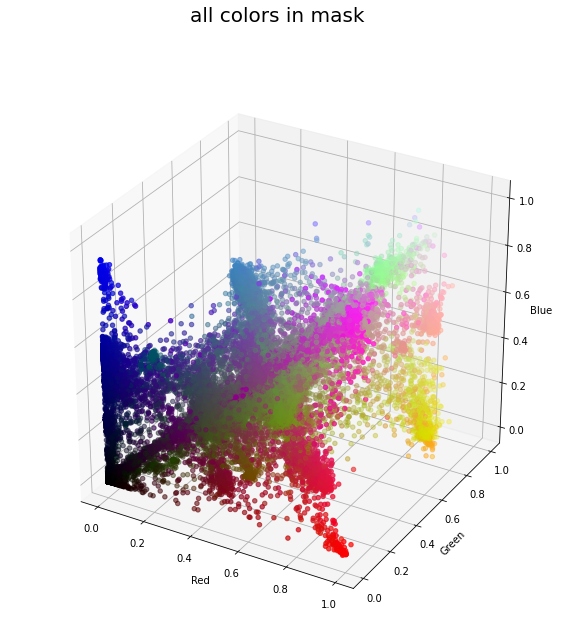

In [8]:
def plot_pixels(data, title, colors = None, N = 100000):
    if colors is None:
        colors = data
    
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    pixel = data[i].T

    R, G, B = pixel[0], pixel[1], pixel[2]

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d', xlabel = 'Red', zlabel = 'Blue', ylabel = 'Green', )
    ax.scatter3D( R, G, B, c=colors, )

    fig.suptitle(title, size=20)

    
images, masks = dirs_to_tensors(train_dir, 
                                iteration=0, 
                                iterations = 25)

img_data = np.array([masks[i].reshape(-1, 3) for i in range(100)]) / 255
img_data = np.concatenate(img_data).astype(np.float32)

plot_pixels(img_data, title='all colors in mask')


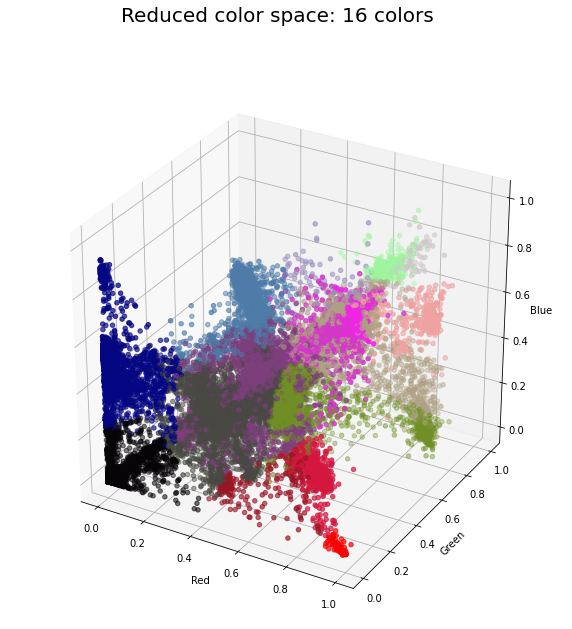

In [9]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
img_data = img_data.astype(np.float32)
campactness, labels, centers = cv2.kmeans(img_data, 16, None, criteria, 10,flags)
new_colors = centers[labels].reshape((-1, 3))
plot_pixels(img_data, colors = new_colors, title = "Reduced color space: 16 colors")

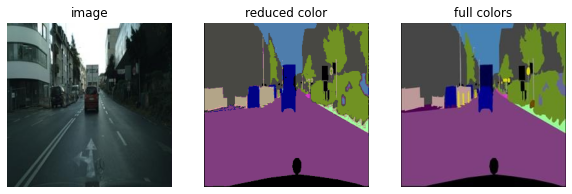

In [10]:
i = 100
reduced_img = array_to_img(np.array(np.split(new_colors, i)).reshape((i, 256, 256, 3))[i - 1])
img = array_to_img(masks[i - 1])
plt.figure(figsize=(10, 16))
plt.subplot(1, 3, 1)
plt.title('image')
plt.axis('off')
plt.imshow(array_to_img(images[i - 1]))
plt.subplot(1, 3, 2)
plt.title('reduced color')
plt.axis('off')
plt.imshow(reduced_img)
plt.subplot(1, 3, 3)
plt.title('full colors')
plt.axis('off')
plt.imshow(img)

Let's build the model

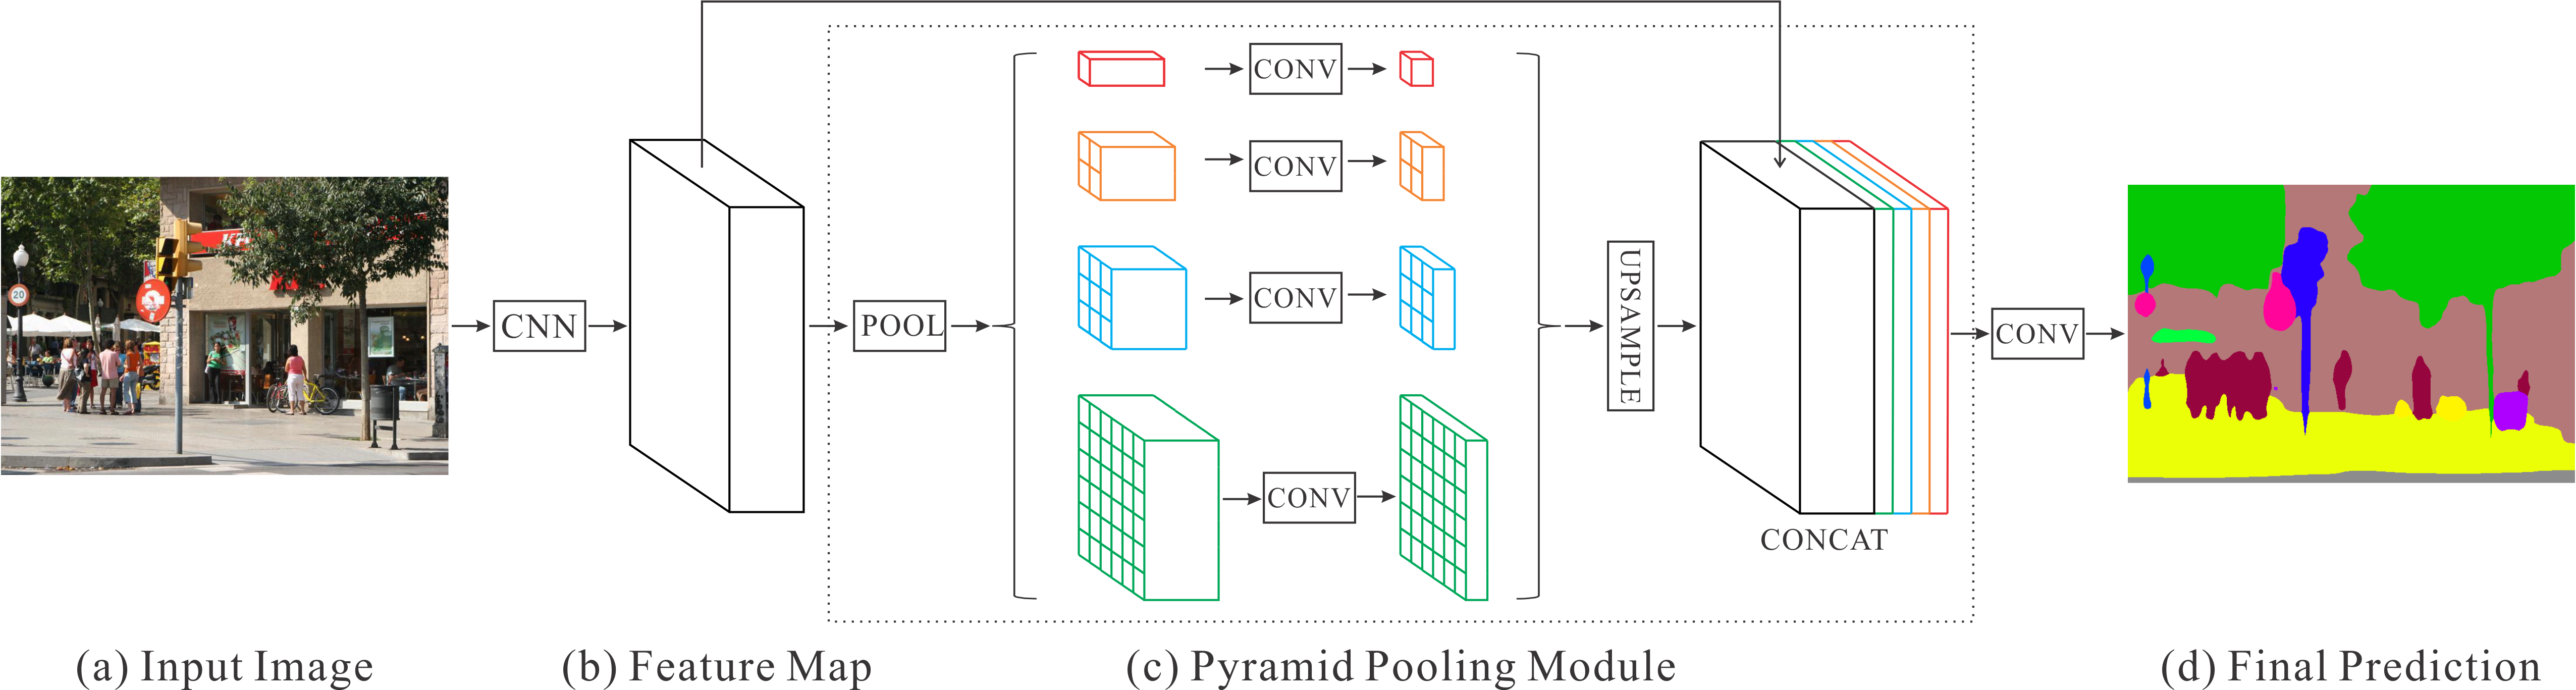

In [11]:
import tensorflow
import numpy as np
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Reshape, concatenate
from tensorflow.keras.layers import UpSampling2D, BatchNormalization
from tensorflow.keras.layers import Activation, LeakyReLU, Lambda, Convolution2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Add, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50V2
import tensorflow.keras.backend as K

images, masks = dirs_to_tensors(train_dir, 
                                iteration=0, 
                                iterations = 20)

exam_img = images[1] / 255
exam_mask = masks[1] / 255


def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X
    
    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X
    # block_a
    X = Convolution2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = Convolution2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
                      padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = Convolution2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Convolution2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps 
    
    # block_1
    base = conv_block(input_layer,[32,32,64],'1')
    # block_2
    base = conv_block(base,[64,64,128],'2')
    # block_3
    base = conv_block(base,[128,128,256],'3')
    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red = GlobalAveragePooling2D(name='red_pool')(base)
    red = tensorflow.keras.layers.Reshape((1,1,256))(red)
    red = Conv2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=256,interpolation='bilinear',name='red_upsampling')(red)
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Conv2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Conv2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Convolution2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    # base + red + yellow + blue + green
    return concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    X = Convolution2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    X = Activation('sigmoid' ,name='last_conv_relu')(X)
    # X = Flatten(name='last_conv_flatten')(X)
    return X

input_layer = tensorflow.keras.Input(shape=np.squeeze(images[0]).shape,name='input')
output_layer = last_conv_module(input_layer)
model = tensorflow.keras.Model(inputs=input_layer,outputs=output_layer)

optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.01)
IoU = tensorflow.keras.metrics.MeanIoU(num_classes=30)
metrics = ['accuracy', IoU]
model.compile(optimizer=optimizer,loss='mse', metrics = metrics)

start: 0; end: 148;


In [ ]:
def train_model(model = model, iterations = 10):
    '''
    training model procces

    Arguments:
        model = current model
        iterations(int): number of iterations
    '''
    from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
    import os
    callbacks = [
        ModelCheckpoint(filepath='/PSPnet/model_best_weights.h5'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)
    ]
    try:
        os.mkdir('/PSPnet')
        os.mkdir('/PSPnet/progress')
    except FileExistsError:
        pass

    history = []
    epochs = 5
    
    for iteration in range(iterations):
        print('-' * 20, f'iteration: {iteration}', '-' * 20 )
        # model.load_weights('/content/drive/MyDrive/PSPnet/model_best_weights.h5')

        images, masks = dirs_to_tensors(train_dir, 
                                        iteration=iteration, 
                                        iterations = iterations)
        test_images, test_masks = dirs_to_tensors(test_dir,
                                                  iteration=iteration, 
                                                  iterations = iterations) 
        
        images, masks = images / 255, masks / 255 
        test_images, test_masks = test_images / 255, test_masks / 255

        

        cur_history = model.fit(
                images, 
                masks,
                validation_data = (test_images, test_masks),
                epochs=epochs,
                verbose=1,
                batch_size=10,
                callbacks = callbacks, )
        

        history.append(cur_history.history)

        model.load_weights('/PSPnet/model_best_weights.h5')    
        
        pred_mask = model.predict(exam_img.reshape(1, 256, 256, 3)).reshape(256,256, 3) * 255
        cv2.imwrite(f'/PSPnet/progress/iteration_{iteration}.jpg', pred_mask, )

train_model()

**Plot results**

In [ ]:
def show_predictions(pred_number):
    model.load_weights('/PSPnet/model_best_weights.h5')
    # pred_mask = cv2.cvtColor(pred_mask, cv2.COLOR_BGR2RGB)
    for i in range(pred_number):
        pred_mask = model.predict((images[i * 4] / 255).reshape(1, 256, 256, 3)).reshape(256,256, 3) * 255
        mask = array_to_img(masks[i * 4])
        img = images[i *4] 
        title = '{1}predicted mask{0}ground truth{0}original image{0}instance segmentation'.format(' ' * 17, ' '* 10)
        instance_seg = array_to_img(img + pred_mask) 
        result = np.hstack([pred_mask, mask,img, instance_seg]) / 255
        plt.figure(figsize=(30, 20))
        plt.subplot(pred_number, 1, i + 1)
        plt.axis('off')
        plt.title(title)
        plt.imshow(result)
    plt.savefig('figure.png')

show_predictions(5)

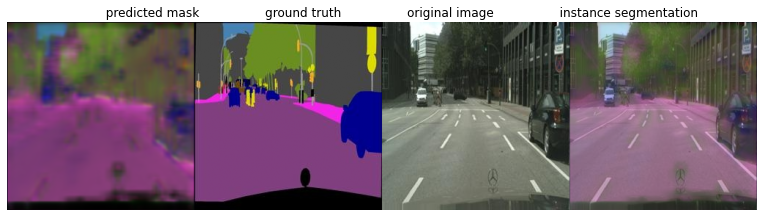

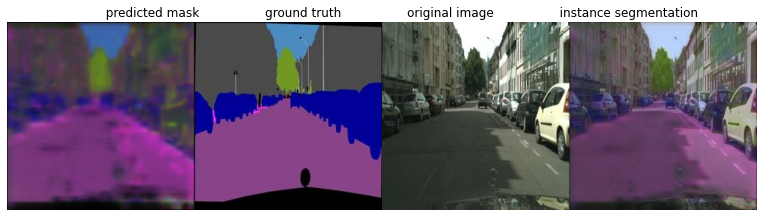

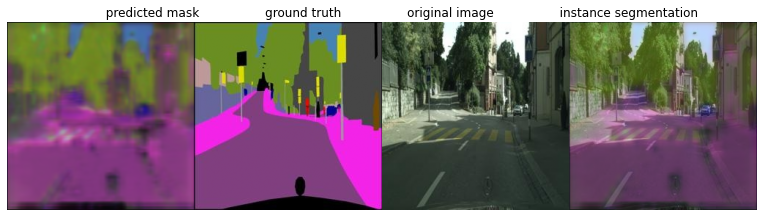

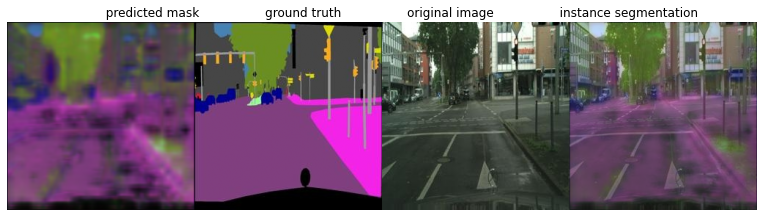

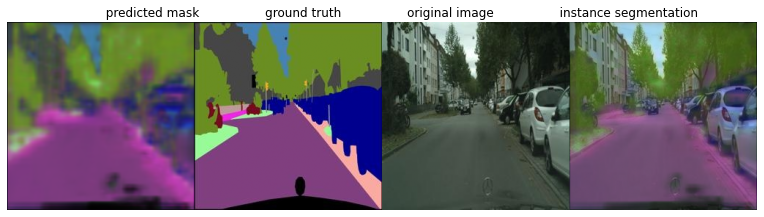

Show Progress

In [ ]:
def show_progress(pred_number):
    import os, cv2
    import numpy as np
    from tensorflow.keras.preprocessing.image import array_to_img
    pred_dir = '/PSPnet/progress'
    prediction_names = [pred_dir + '/' + filename  for filename in os.listdir(pred_dir)]
    mask = array_to_img(masks[1])
    img = images[1]
    
    for i in range(len(prediction_names)):
        pred_mask = cv2.imread(prediction_names[1], )
        title = 'iteration: ' + str(i + 1) 
        instance_seg = array_to_img(img + pred_mask) 
        result = np.hstack([pred_mask, mask,img, instance_seg]) / 255
        plt.figure(figsize=(40, 40))
        plt.subplot(pred_number, 1, i + 1)
        plt.axis('off')
        plt.title(title)
        plt.imshow(result)

show_progress(10)

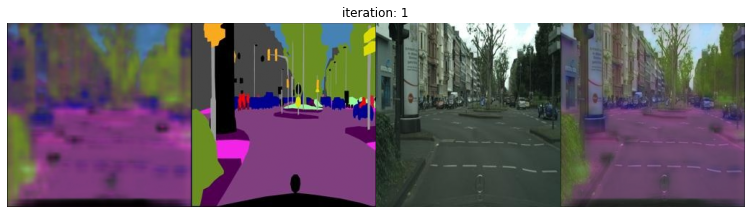

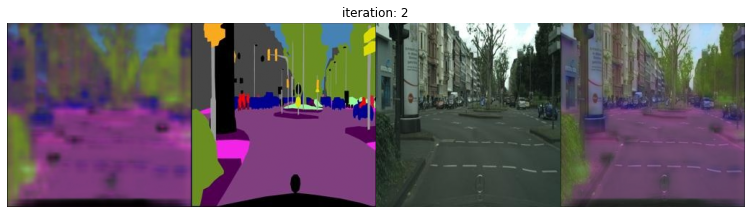

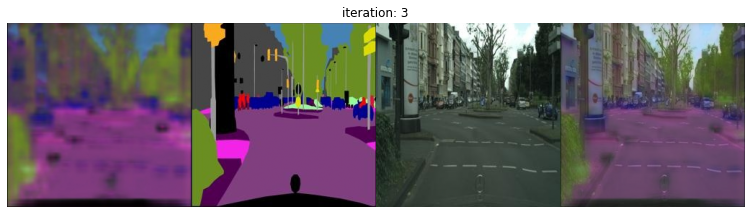

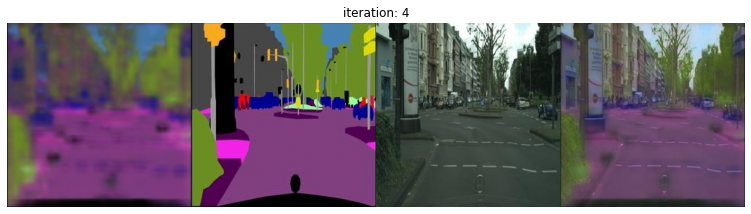

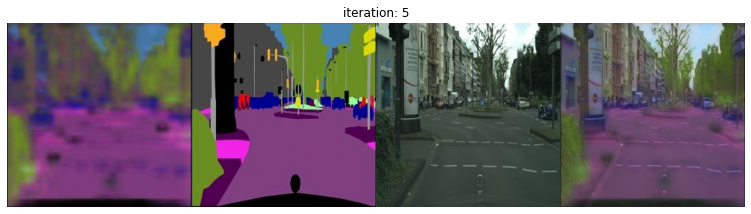

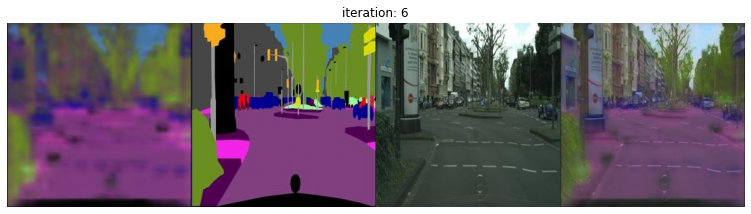

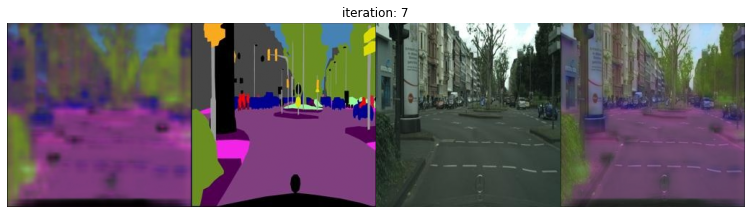

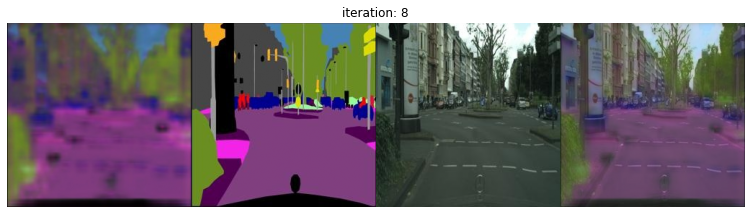

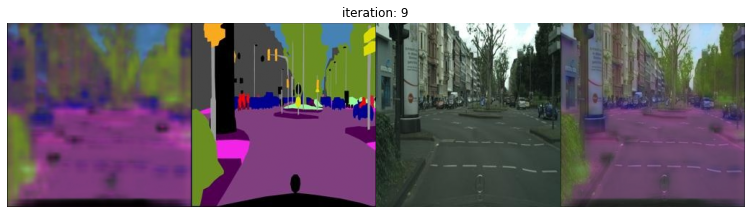

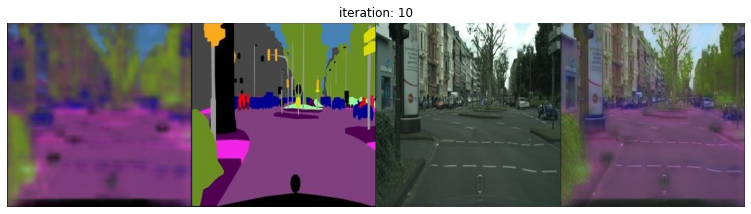